In [ ]:
# comment this block and use as per your pc, this is for windows
import findspark
findspark.init("C:/spark") 

from pyspark import SparkContext
sc=SparkContext("local","Pyspark new")

In [1]:
import os
import findspark

os.environ["SPARK_HOME"] = "//home/hadoop/spark-3.5.6-bin-hadoop3"  # your Spark install path
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.11.0-openjdk-amd64"

findspark.init()

In [2]:
from pyspark import SparkContext
sc=SparkContext("local","Pyspark new")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/21 14:20:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print("Spark Version:", spark.version)

Spark Version: 3.5.6


In [8]:
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt

# PHASE 1- DATASET UNDERSTANDING AND SETUP

#### Vikasan's part

In [7]:
from pyspark.sql.functions import * 

In [5]:
clickstream_df = spark.read \
    .option("delimiter", "\t") \
    .option("header",False)\
    .option("InferSchema",True)\
    #.csv("file:///home/hadoop/Desktop/BDA_miniproj/dataset/clickstream-enwiki-2025-07.tsv") #in linux
    #.csv(r"dataset\clickstream-enwiki-2025-07.tsv")    #windows

In [6]:
columns = ["prev", "curr", "type", "n"]
clickstream_df = clickstream_df.toDF(*columns)  # writing the column headers

# show few rows
clickstream_df.show(10)

+-------------------+--------------------+--------+---------+
|               prev|                curr|    type|        n|
+-------------------+--------------------+--------+---------+
|        other-empty|           Main_Page|external|167194874|
|Meteor_(miniseries)|     Ernie_Barbarash|    link|       13|
|       other-search|       Ozzy_Osbourne|external|  7956732|
|   Meteor_(missile)|                Euro|    link|       13|
|        other-empty|        Hyphen-minus|external|  7819580|
|   Meteor_(missile)|      Royal_Ordnance|    link|       13|
|     other-internal|           Main_Page|external|  6902577|
|   Meteor_(missile)|Saab_Bofors_Dynamics|    link|       13|
|       other-search|Superman_(2025_film)|external|  5462456|
|   Meteor_(missile)|     Sukhoi_Su-30MKI|    link|       13|
+-------------------+--------------------+--------+---------+
only showing top 10 rows



In [7]:
clickstream_df.columns

['prev', 'curr', 'type', 'n']

In [8]:
noOfRows= clickstream_df.count()

In [9]:
noOfRows

36131419

#### Prajwal's part

In [10]:
# do your part here 

In [11]:
# check the schema
clickstream_df.printSchema()
clickstream_df.show(5, truncate=False)

root
 |-- prev: string (nullable = true)
 |-- curr: string (nullable = true)
 |-- type: string (nullable = true)
 |-- n: integer (nullable = true)

+-------------------+---------------+--------+---------+
|prev               |curr           |type    |n        |
+-------------------+---------------+--------+---------+
|other-empty        |Main_Page      |external|167194874|
|Meteor_(miniseries)|Ernie_Barbarash|link    |13       |
|other-search       |Ozzy_Osbourne  |external|7956732  |
|Meteor_(missile)   |Euro           |link    |13       |
|other-empty        |Hyphen-minus   |external|7819580  |
+-------------------+---------------+--------+---------+
only showing top 5 rows



In [12]:
# checking nulls
missing_counts = clickstream_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in clickstream_df.columns
])
missing_counts.show()

+----+----+----+---+
|prev|curr|type|  n|
+----+----+----+---+
|   0|   0|   0|  0|
+----+----+----+---+



In [13]:
stats = clickstream_df.select(
    min("n").alias("minOf_n"),
    max("n").alias("maxOf_n"),
    mean("n").alias("meanOf_n")
)


In [14]:
stats.show()

+-------+---------+------------------+
|minOf_n|  maxOf_n|          meanOf_n|
+-------+---------+------------------+
|     10|167194874|181.54733773395392|
+-------+---------+------------------+



In [15]:
a=clickstream_df.orderBy(col("n").asc()).select("prev","curr","n").limit(1)
b=clickstream_df.orderBy(col("n").desc()).select("prev","curr","n").limit(1)

In [16]:
a.show()
b.show()

+----+------------------+---+
|prev|              curr|  n|
+----+------------------+---+
|  !!|!_(disambiguation)| 10|
+----+------------------+---+

+-----------+---------+---------+
|       prev|     curr|        n|
+-----------+---------+---------+
|other-empty|Main_Page|167194874|
+-----------+---------+---------+



#### Dhruva's part

In [17]:
# do your part here 
# inspect curr, prev, link (distribution analysis)

In [18]:
# Find rows where n is not a pure number
df_invalid_n = clickstream_df.filter(~col("n").cast("string").rlike("^[0-9]+$"))
df_invalid_n.show(20, truncate=False)

# Count them
print("Invalid n rows:", df_invalid_n.count())



+----+----+----+---+
|prev|curr|type|n  |
+----+----+----+---+
+----+----+----+---+

Invalid n rows: 0


In [19]:
#inspect 'type column'
clickstream_df.groupBy("type").count().show(truncate=False)

+--------+--------+
|type    |count   |
+--------+--------+
|link    |22940461|
|other   |790412  |
|external|12400546|
+--------+--------+



In [20]:
# inspect 'prev' column
clickstream_df.groupBy("prev").count().orderBy(desc("count")).show(20, truncate=False)        

+-------------------------------------------------------------+-------+
|prev                                                         |count  |
+-------------------------------------------------------------+-------+
|other-empty                                                  |5696646|
|other-search                                                 |4075166|
|other-internal                                               |1785075|
|other-external                                               |642457 |
|Main_Page                                                    |263151 |
|other-other                                                  |201202 |
|Deaths_in_2025                                               |5616   |
|Wikipedia                                                    |3684   |
|Wiki                                                         |2743   |
|List_of_United_States_counties_and_county_equivalents        |2480   |
|List_of_American_films_of_2025                               |2

# PHASE 2 - DATA PREPROCESSING

In [21]:
from pyspark.sql.functions import *

#### Vikasan's part
- we are dropping the rows that have 'prev' = 'other -other' as it doesn’t give meaningful context about where the user came from.

In [22]:
# Remove rows where 'prev' is 'other-empty'
other_prev_col = clickstream_df.filter(col('prev') == 'other-other')

In [23]:
other_prev_col.count()

201202

In [24]:
clickstream_df = clickstream_df.filter(col('prev') != 'other-other')

In [ ]:
print("After dropping 'other-other' rows from prev column: \n")
clickstream_df.show()

After dropping 'other-other' rows from prev column: 

+-------------------+--------------------+--------+---------+
|               prev|                curr|    type|        n|
+-------------------+--------------------+--------+---------+
|        other-empty|           Main_Page|external|167194874|
|Meteor_(miniseries)|     Ernie_Barbarash|    link|       13|
|       other-search|       Ozzy_Osbourne|external|  7956732|
|   Meteor_(missile)|                Euro|    link|       13|
|        other-empty|        Hyphen-minus|external|  7819580|
|   Meteor_(missile)|      Royal_Ordnance|    link|       13|
|     other-internal|           Main_Page|external|  6902577|
|   Meteor_(missile)|Saab_Bofors_Dynamics|    link|       13|
|       other-search|Superman_(2025_film)|external|  5462456|
|   Meteor_(missile)|     Sukhoi_Su-30MKI|    link|       13|
|       other-search|          Hulk_Hogan|external|  4169217|
|    Meteor_Airlines|             Tinghir|    link|       13|
|       other-se

In [25]:
clickstream_df.count()

35930217

In [ ]:
#clickstream_df = clickstream_df.dropna() #No nulls

In [ ]:
#  run this once and keep it in your dataset folder (gitignore)
#clickstream_df.write.parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/cleaned_clickstream.parquet")

#### Prajwal's part

- Why Parquet?
    - Columnar storage - faster reads for analytics and ML.
    - Schema-preserving - int, string, etc. are stored as-is.
    - Highly compressed - smaller on disk compared to CSV/TSV.

In [42]:
# Load cleaned dataset from Parquet, use this for future analysis
cleaned_df = spark.read.parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/cleaned_clickstream.parquet") #on ubuntu
#cleaned_df = spark.read.parquet("dataset/cleaned_clickstream.parquet") #for windows

In [43]:
cleaned_df.printSchema()

root
 |-- prev: string (nullable = true)
 |-- curr: string (nullable = true)
 |-- type: string (nullable = true)
 |-- n: integer (nullable = true)



In [33]:
cleaned_df.count()

35930217

In [29]:
cleaned_df.show()

+--------------------+--------------------+----+---+
|                prev|                curr|type|  n|
+--------------------+--------------------+----+---+
|List_of_ISO_639_l...|    Bihari_languages|link| 82|
|List_of_Ice_Age_s...| Cervalces_latifrons|link| 82|
|List_of_Ig_Nobel_...|Alexander_Lukashenko|link| 82|
|List_of_Illuminat...|      Curious_George|link| 82|
|List_of_India_Tes...|         Dilip_Doshi|link| 82|
|List_of_India_Tes...|         Munaf_Patel|link| 82|
|List_of_India_Twe...|        Harshit_Rana|link| 82|
|List_of_Indian_Ch...|        Vijay_Hazare|link| 82|
|List_of_Indian_Gr...|       Shakti_(band)|link| 82|
|List_of_Indian_IT...|           Collabera|link| 82|
|List_of_Indian_NH...|      Manny_Malhotra|link| 82|
|List_of_Indian_No...|         Ronald_Ross|link| 82|
|List_of_Indian_di...|List_of_snack_foo...|link| 82|
|List_of_Indian_ho...|       Manipuri_pony|link| 82|
|List_of_Indian_in...|V._O._Chidambaram...|link| 82|
|List_of_Indian_ma...|       Abbas_(actor)|lin

In [31]:
# Encoding 'type' column: link=0, external=1, other=2
cleaned_df = cleaned_df.withColumn(
    "type_encoded",
    when(cleaned_df["type"] == "link", 0)
    .when(cleaned_df["type"] == "external", 1)
    .when(cleaned_df["type"] == "other", 2)
)

# Check result
cleaned_df.select("type", "type_encoded").distinct().show()

from pyspark.sql.functions import log1p

# Normalize click counts
cleaned_df = cleaned_df.withColumn("normalized_clicks", log1p(cleaned_df["n"]))

+--------+------------+
|    type|type_encoded|
+--------+------------+
|external|           1|
|   other|           2|
|    link|           0|
+--------+------------+



In [32]:
cleaned_df.select("prev", "curr", "type", "n", "type_encoded", "normalized_clicks").show(10, truncate=False)

+-------------------------------------------------------+--------------------+----+---+------------+-----------------+
|prev                                                   |curr                |type|n  |type_encoded|normalized_clicks|
+-------------------------------------------------------+--------------------+----+---+------------+-----------------+
|List_of_ISO_639_language_codes                         |Bihari_languages    |link|82 |0           |4.418840607796598|
|List_of_Ice_Age_species_preserved_as_permafrost_mummies|Cervalces_latifrons |link|82 |0           |4.418840607796598|
|List_of_Ig_Nobel_Prize_winners                         |Alexander_Lukashenko|link|82 |0           |4.418840607796598|
|List_of_Illumination_productions                       |Curious_George      |link|82 |0           |4.418840607796598|
|List_of_India_Test_cricketers                          |Dilip_Doshi         |link|82 |0           |4.418840607796598|
|List_of_India_Test_cricketers                  

In [40]:
cleaned_df.groupBy('type_encoded').count().show()

+------------+--------+
|type_encoded|   count|
+------------+--------+
|           1|12199344|
|           2|  790412|
|           0|22940461|
+------------+--------+



In [41]:
cleaned_df.write.mode("overwrite").parquet(r"file:///home/hadoop/Desktop/BDA_miniproj/dataset/feature_engineered_clickstream.parquet")

In [44]:
print("Feature engineering complete. Saved as 'feature_engineered_clickstream.parquet'")


Feature engineering complete. Saved as 'feature_engineered_clickstream.parquet'


#### Dhruva's part

In [45]:
feature_df= spark.read.parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/feature_engineered_clickstream.parquet")

feature_df.printSchema()
feature_df.show(5, truncate=False)

root
 |-- prev: string (nullable = true)
 |-- curr: string (nullable = true)
 |-- type: string (nullable = true)
 |-- n: integer (nullable = true)
 |-- type_encoded: integer (nullable = true)
 |-- normalized_clicks: double (nullable = true)

+--------------------------------+----------------------------+----+---+------------+------------------+
|prev                            |curr                        |type|n  |type_encoded|normalized_clicks |
+--------------------------------+----------------------------+----+---+------------+------------------+
|Ethnic_groups_in_the_Middle_East|Armenians_in_the_Middle_East|link|17 |0           |2.8903717578961645|
|Ethnic_groups_in_the_Middle_East|Assyrians_in_Georgia        |link|17 |0           |2.8903717578961645|
|Ethnic_groups_in_the_Middle_East|Demographics_of_Oman        |link|17 |0           |2.8903717578961645|
|Ethnic_groups_in_the_Middle_East|Qashqai_people              |link|17 |0           |2.8903717578961645|
|Ethnic_groups_in_the_P

In [46]:
expected_schema = ["prev", "curr", "type", "n", "type_encoded", "normalized_clicks"]

if list(feature_df.columns) == expected_schema:
    print("schema check passed.")
else:
    print("schema mismatch, verify columns:")
    print(feature_df.columns)

schema check passed.


In [47]:
null_counts = feature_df.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in feature_df.columns
])
print(" Null/NaN counts (if any)")
null_counts.show()

 Null/NaN counts (if any)


+----+----+----+---+------------+-----------------+
|prev|curr|type|  n|type_encoded|normalized_clicks|
+----+----+----+---+------------+-----------------+
|  20|  35|   0|  0|           0|                0|
+----+----+----+---+------------+-----------------+



In [48]:
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)
print(f"Dataset split for checking anomaly: Train = {train_df.count()}, Test = {test_df.count()}")

# Step 5: Save final datasets
train_df.write.mode("overwrite").parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/final_train_clickstream.parquet")
test_df.write.mode("overwrite").parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/final_test_clickstream.parquet")

Dataset split for checking anomaly: Train = 28742717, Test = 7187500


# Phase 3- Anomaly detection

### Vikasan's Part
- Detect Statistical Outliers
- Compute mean and standard deviation of n
- Calculate Z-scores and identify outlier navigation pairs


In [56]:
import matplotlib.pyplot as plt

In [4]:
train_df= spark.read.parquet("file:///home/hadoop/Desktop/BDA_miniproj/dataset/final_train_clickstream.parquet")

In [5]:
train_df.show(2)

+----+--------------------+----+---+------------+-----------------+
|prev|                curr|type|  n|type_encoded|normalized_clicks|
+----+--------------------+----+---+------------+-----------------+
|  !!|!!!_(disambiguation)|link| 15|           0|2.772588722239781|
|  !!|Double-negation_t...|link| 21|           0|3.091042453358316|
+----+--------------------+----+---+------------+-----------------+
only showing top 2 rows



In [9]:
stats_n = train_df.select(
    mean("normalized_clicks").alias("mean_n"),
    stddev("normalized_clicks").alias("stddev_n")
).first()

mean_n = stats_n["mean_n"]
stddev_n = stats_n["stddev_n"]



In [10]:
print(f"Mean (n): {mean_n}")
print(f"Standard Deviation (n): {stddev_n}")
 
# Z-scores for n
df_with_zscore = train_df.withColumn("zscore_n", (col("normalized_clicks") - mean_n) / stddev_n)
df_with_zscore = df_with_zscore.withColumn("abs_zscore", abs(col("zscore_n")))

# 3. Identify outliers (|Z| > 3)
outlier_threshold = 3
statistical_outliers = df_with_zscore.filter(col("abs_zscore") > outlier_threshold)


Mean (n): 3.656209076874831
Standard Deviation (n): 1.1974714085497082


In [11]:
print(f"Found {statistical_outliers.count()} statistical outliers (|Z| > 3):")
statistical_outliers.orderBy(desc("abs_zscore")).show(20, truncate=False)

Found 469235 statistical outliers (|Z| > 3):


+--------------+-------------------------------+--------+-------+------------+------------------+------------------+------------------+
|prev          |curr                           |type    |n      |type_encoded|normalized_clicks |zscore_n          |abs_zscore        |
+--------------+-------------------------------+--------+-------+------------+------------------+------------------+------------------+
|other-search  |Ozzy_Osbourne                  |external|7956732|1           |15.889529046436618|10.215959965489205|10.215959965489205|
|other-empty   |Hyphen-minus                   |external|7819580|1           |15.872141530523344|10.20143977253167 |10.20143977253167 |
|other-search  |Superman_(2025_film)           |external|5462456|1           |15.513409246501453|9.901864950568813 |9.901864950568813 |
|other-search  |Hulk_Hogan                     |external|4169217|1           |15.24323904621302 |9.676247705464277 |9.676247705464277 |
|other-search  |Malcolm-Jamal_Warner           |

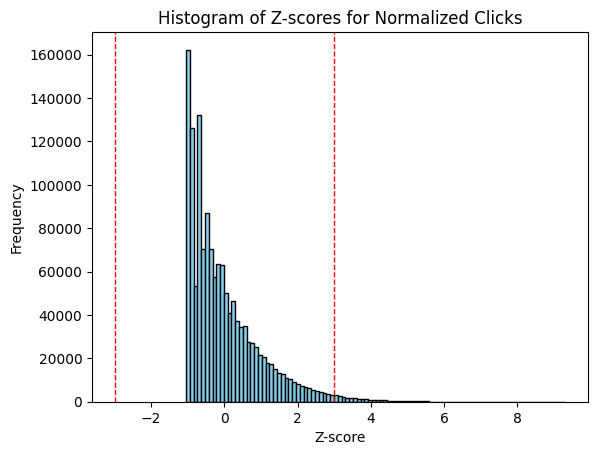

In [15]:
# Sample 50k rows
sample_z = df_with_zscore.select("zscore_n")\
                         .sample(fraction=0.05, seed=42)\
                         .rdd.flatMap(lambda x: x)\
                         .collect()

plt.hist(sample_z, bins=100, color='skyblue', edgecolor='black')
plt.axvline(3, color='red', linestyle='dashed', linewidth=1)
plt.axvline(-3, color='red', linestyle='dashed', linewidth=1)
plt.title("Histogram of Z-scores for Normalized Clicks")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.show()


In [ ]:

# 4. Save the list of statistically anomalous navigation pairs
# statistical_outliers.write.mode("overwrite").parquet(
#     "file:///home/hadoop/Desktop/BDA_miniproj/results/statistical_outliers.parquet"
# )

# print("Statistical outliers saved successfully.")